<a href="https://colab.research.google.com/github/scottthomaswx/RAP-Analysis/blob/main/RAPAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture
!pip install siphon
!pip install xarray
!pip install metpy
!pip install matplotlib
!pip install numpy
!pip install cartopy
!pip install warnings
!pip install netCDF4
#Import Packages
from siphon.catalog import TDSCatalog
import xarray as xr
import metpy
from metpy.units import units
import matplotlib.pyplot as plt
import numpy as np
import cartopy.feature as cfeature
import cartopy.crs as ccrs
import metpy.calc as mpcalc
import warnings
warnings.filterwarnings('ignore')
from metpy.plots import ctables
import netCDF4

In [77]:
year = "2023" # @param {type:"string"}
month = "10" # @param {type:"string"}
day = "31" # @param {type:"string"}
hour_utc = "15" # @param {type:"string"}
WestLong = -125 # @param {type:"number"}
EastLong = -70 # @param {type:"number"}
NorthLat = 50 # @param {type:"number"}
SouthLat = 23 # @param {type:"number"}
variable = 'Surface Pressure/Wind' # @param ["Synoptic 4-Panel", "250 mb Analysis", "500 mb Vorticity", "500 mb Winds", "850 mb Analysis 1", "850 mb Analysis 2", "Surface Temperature", "Surface Dewpoint", "Surface Pressure/Wind"]
timetype = 'Archive' # @param ["Realtime", "Archive"]



In [78]:
#Pull Rap Data For Case/Selected Time/Date And Open Dataset
if timetype == 'Archive':
  tds_RAP=TDSCatalog(f'https://www.ncei.noaa.gov/thredds/catalog/model-rap130anl/{year}{month}/{year}{month}{day}/catalog.html?dataset=rap130anl/{year}{month}/{year}{month}{day}/rap_130_{year}{month}{day}_{hour_utc}00_001.grb2')
if timetype == 'Realtime':
  tds_RAP=TDSCatalog(f'https://thredds.ucar.edu/thredds/catalog/grib/NCEP/RAP/CONUS_13km/latest.html')
rap_ds=tds_RAP.datasets[0]
ds=xr.open_dataset(rap_ds.access_urls['OPENDAP'])


In [79]:
#pull parameters
mSLP=ds.metpy.parse_cf('MSLP_MAPS_System_Reduction_msl').metpy.convert_units('hPa')

gph2=ds.metpy.parse_cf('Geopotential_height_isobaric')
level_def2=np.where(gph2.isobaric==25000)[0][0]
gph2select=gph2.isel(isobaric=level_def2).metpy.convert_units('dam')

gph5=ds.metpy.parse_cf('Geopotential_height_isobaric')
level_def5=np.where(gph5.isobaric==50000)[0][0]
gph5select=gph5.isel(isobaric=level_def5).metpy.convert_units('dam')

gph8=ds.metpy.parse_cf('Geopotential_height_isobaric')
level_def8=np.where(gph2.isobaric==85000)[0][0]
gph8select=gph8.isel(isobaric=level_def8).metpy.convert_units('dam')

u_wind2=ds.metpy.parse_cf('u-component_of_wind_isobaric').isel(isobaric=level_def2).metpy.convert_units('kts')
v_wind2=ds.metpy.parse_cf('v-component_of_wind_isobaric').isel(isobaric=level_def2).metpy.convert_units('kts')

u_wind5=ds.metpy.parse_cf('u-component_of_wind_isobaric').isel(isobaric=level_def5).metpy.convert_units('kts')
v_wind5=ds.metpy.parse_cf('v-component_of_wind_isobaric').isel(isobaric=level_def5).metpy.convert_units('kts')

u_wind8=ds.metpy.parse_cf('u-component_of_wind_isobaric').isel(isobaric=level_def8).metpy.convert_units('kts')
v_wind8=ds.metpy.parse_cf('v-component_of_wind_isobaric').isel(isobaric=level_def8).metpy.convert_units('kts')

TMP2m=ds.metpy.parse_cf('Temperature_height_above_ground')
sfctmplevel=np.where(TMP2m.height_above_ground2 == 2. )[0][0]
sfcTMP=TMP2m.isel(height_above_ground2=sfctmplevel).metpy.convert_units('degC')

div=mpcalc.divergence(u_wind2,v_wind2, dx=	13.545087*units.km, dy=	13.545087*units.km).metpy.convert_units('1/s')
div/=10**-5

T_UA8 = ds.metpy.parse_cf('Temperature_isobaric').isel(isobaric=level_def8).metpy.convert_units('degC')

abs_vort5 =mpcalc.vorticity(u_wind5,v_wind5, dx=	13.545087*units.km, dy=	13.545087*units.km).metpy.convert_units('1/s')
abs_vort5/=10**-5

sfc_u=ds.metpy.parse_cf('u-component_of_wind_height_above_ground')
sfc_v=ds.metpy.parse_cf('v-component_of_wind_height_above_ground')
sfc_level=np.where(sfc_u.height_above_ground5==10.)[0][0]
sfc_u_wind=ds.metpy.parse_cf('u-component_of_wind_height_above_ground').isel(height_above_ground5=sfc_level).metpy.convert_units('knots')
sfc_v_wind=ds.metpy.parse_cf('v-component_of_wind_height_above_ground').isel(height_above_ground5=sfc_level).metpy.convert_units('knots')

wind2=mpcalc.wind_speed(u_wind2,v_wind2)
wind5=mpcalc.wind_speed(u_wind5,v_wind5)
wind8=mpcalc.wind_speed(u_wind8,v_wind8)

DPT2m=ds.metpy.parse_cf('Dewpoint_temperature_height_above_ground')
sfcdptlevel=np.where(DPT2m.height_above_ground == 2. )[0][0]
sfcDPT=DPT2m.isel(height_above_ground=sfcdptlevel).metpy.convert_units('degC')


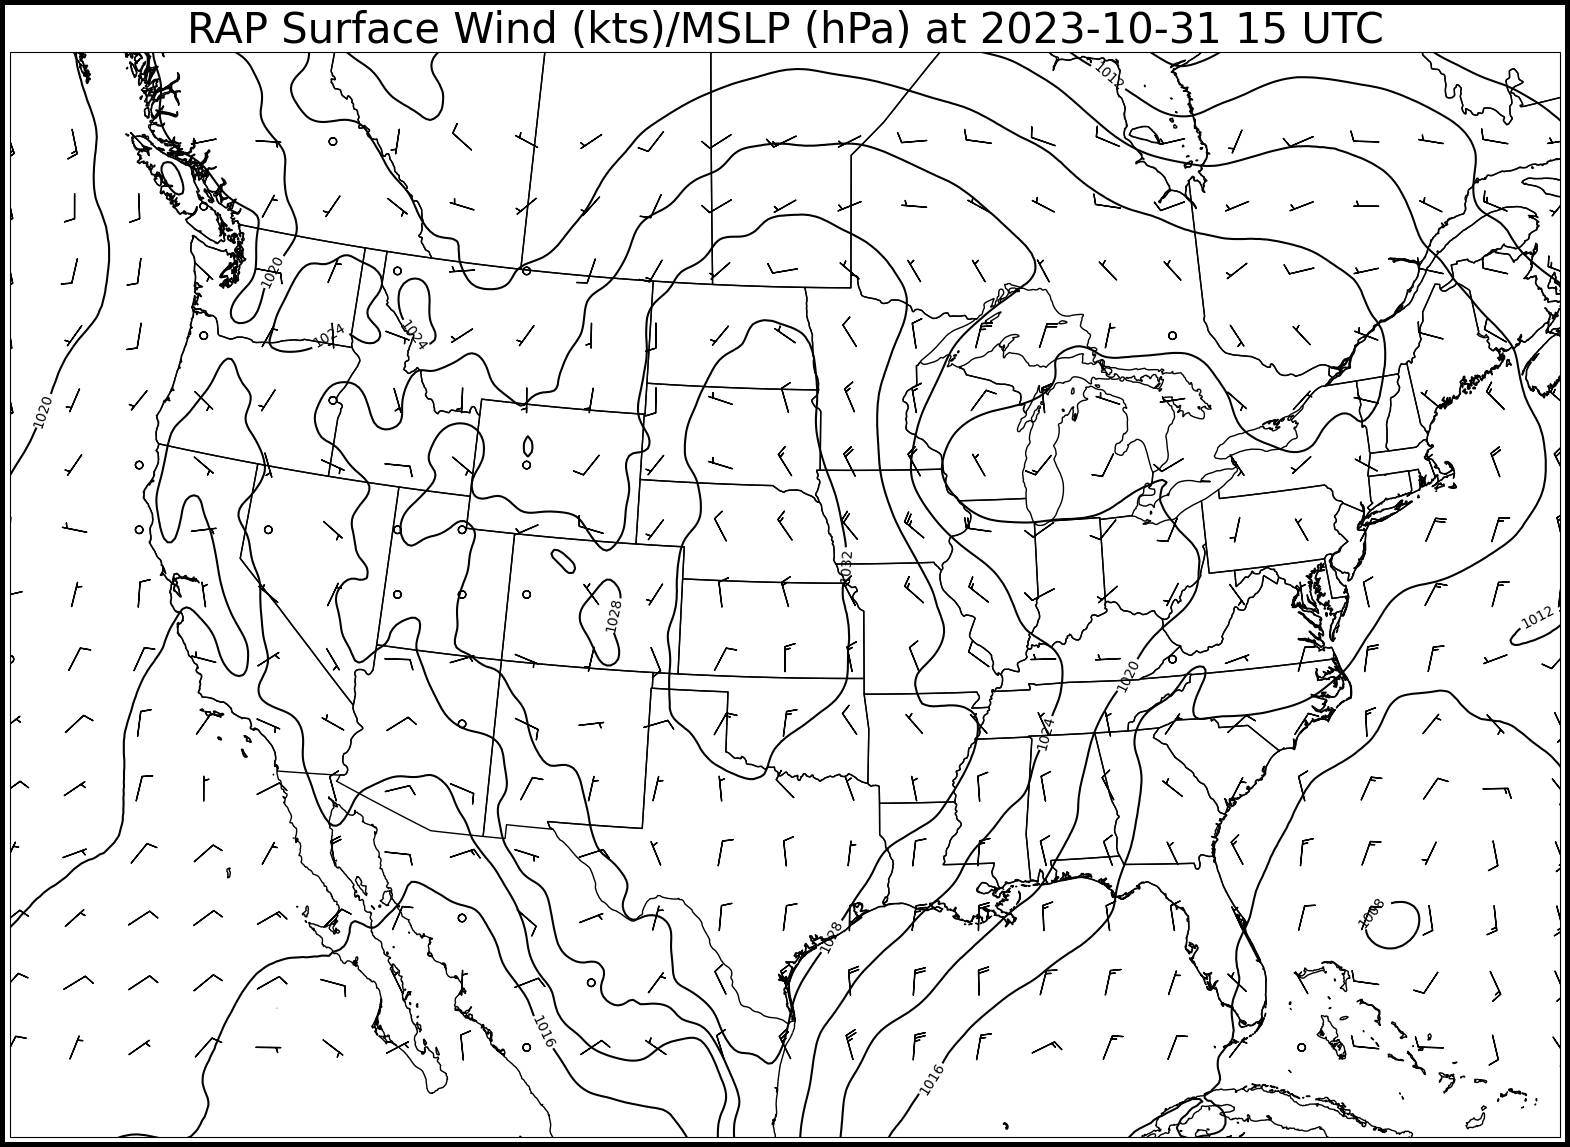

In [83]:
if variable == 'Synoptic 4-Panel':
  fig = plt.figure(figsize=(20,15), edgecolor="black", linewidth =6)

  ax1=fig.add_subplot(2,2,1,projection=mSLP.metpy.cartopy_crs)
  ax2=fig.add_subplot(2,2,2,projection=mSLP.metpy.cartopy_crs)
  ax3=fig.add_subplot(2,2,3,projection=mSLP.metpy.cartopy_crs)
  ax4=fig.add_subplot(2,2,4,projection=mSLP.metpy.cartopy_crs)

  ax1.set_extent([WestLong, EastLong, SouthLat, NorthLat])
  ax2.set_extent([WestLong, EastLong, SouthLat, NorthLat])
  ax3.set_extent([WestLong, EastLong, SouthLat, NorthLat])
  ax4.set_extent([WestLong, EastLong, SouthLat, NorthLat])
  ax1.set_box_aspect(0.7)
  ax2.set_box_aspect(0.7)
  ax3.set_box_aspect(0.7)
  ax4.set_box_aspect(0.7)


  ax1.coastlines(color='black',resolution='10m',zorder=99)
  ax1.add_feature(cfeature.STATES.with_scale('50m'),edgecolor='black')

  ax1.set_title(f'RAP 250 mb Wind (kts)/Height (dam) at {year}-{month}-{day} {hour_utc} UTC')

  ax2.coastlines(color='black',resolution='10m',zorder=99)
  ax2.add_feature(cfeature.STATES.with_scale('50m'),edgecolor='black')

  ax2.set_title(f'RAP 500 mb Wind (kts)/Height (dam)/Vorticity (10^-5 s^-1) at {year}-{month}-{day} {hour_utc} UTC')

  ax3.coastlines(color='black',resolution='10m',zorder=99)
  ax3.add_feature(cfeature.STATES.with_scale('50m'),edgecolor='black')

  ax3.set_title(f'RAP 850 mb Wind (kts)/Height (dam)/Temperature (°C) at {year}-{month}-{day} {hour_utc} UTC')

  ax4.coastlines(color='black',resolution='10m',zorder=99)
  ax4.add_feature(cfeature.STATES.with_scale('50m'),edgecolor='black')

  ax4.set_title(f'RAP MSLP (hPa)/Wind (kts)/Temperature (°C) at {year}-{month}-{day} {hour_utc} UTC')


  wind_fill = ax1.contourf(wind2.x,wind2.y,wind2.isel(time1=0), cmap='BuPu', levels=np.arange(60,201,20))
  plt.colorbar(wind_fill,orientation='horizontal',pad=0.0, aspect=50, ax=ax1, label='Wind Speed (kts)', shrink = 0.91)
  ax1.barbs(u_wind2.x.values, u_wind2.y.values, u_wind2.isel(time1=0).values, v_wind2.isel(time1=0).values, pivot='middle', color='black', regrid_shape=15, linewidth=0.5, length = 5)

  gph_lines2=ax1.contour(gph2select.x,gph2select.y,gph2select.isel(time1=0), colors='black', levels=np.arange(880,1180,6))
  ax1.clabel(gph_lines2,fmt='%4d', colors='black')

  gph_lines5=ax2.contour(gph5select.x,gph5select.y,gph5select.isel(time1=0), colors='black', levels=np.arange(420,660,6))
  ax2.clabel(gph_lines5,fmt='%4d', colors='black')

  vort_fill = ax2.contourf(abs_vort5.x, abs_vort5.y, abs_vort5.isel(time1=0), cmap = 'autumn_r', levels = np.arange(12,61, 4))
  plt.colorbar(vort_fill,orientation='horizontal',pad=0.0, aspect=50, label='Vorticity (10^-5 s^-1)', ax = ax2 , shrink = 0.91 )

  ax2.barbs(u_wind5.x.values, u_wind5.y.values, u_wind5.isel(time1=0).values, v_wind5.isel(time1=0).values, pivot='middle', color='black', regrid_shape=15, linewidth=0.5, length = 5)

  gph_lines8=ax3.contour(gph8select.x,gph8select.y,gph8select.isel(time1=0), colors='black', levels=np.arange(12,252,3))
  ax3.clabel(gph_lines8,fmt='%4d', colors='black')

  temp_fill = ax3.contourf(T_UA8.x, T_UA8.y, T_UA8.isel(time1=0), cmap = 'jet', levels = np.arange(-40,41, 4))
  plt.colorbar(temp_fill,orientation='horizontal',pad=0.0, aspect=50, label='Temperature (°C)', ax = ax3 , shrink = 0.91)

  ax3.barbs(u_wind8.x.values, u_wind8.y.values, u_wind8.isel(time1=0).values, v_wind8.isel(time1=0).values, pivot='middle', color='black', regrid_shape=15, linewidth=0.5, length = 5)

  mSLP_lines=ax4.contour(mSLP.x, mSLP.y, mSLP.isel(time1=0), colors='black', levels=np.arange(960,1040,4))
  ax4.clabel(mSLP_lines,fmt='%4d', colors='black')

  sfctemp_fill = ax4.contourf(sfcTMP.x, sfcTMP.y, sfcTMP.isel(time1=0), cmap = 'jet', levels = np.arange(-40,41, 4))
  plt.colorbar(sfctemp_fill,orientation='horizontal',pad=0.0, aspect=50, label='Temperature (°C)', ax = ax4 , shrink = 0.91)

  ax4.barbs(sfc_u_wind.x.values, sfc_u_wind.y.values, sfc_u_wind.isel(time1=0).values,sfc_v_wind.isel(time1=0).values, pivot='middle', color='black', regrid_shape=15, linewidth=0.5, length = 5)

  plt.savefig(f'SynopticAnalysis_{year}{month}{day}{hour_utc}')

if variable == '250 mb Analysis':
  fig = plt.figure(figsize=(20,15), edgecolor="black", linewidth =6)

  ax1=fig.add_subplot(1,1,1,projection=mSLP.metpy.cartopy_crs)

  ax1.set_extent([WestLong, EastLong, SouthLat, NorthLat])

  ax1.set_box_aspect(0.7)

  ax1.coastlines(color='black',resolution='10m',zorder=99)
  ax1.add_feature(cfeature.STATES.with_scale('50m'),edgecolor='black')

  ax1.set_title(f'RAP 250 mb Wind (kts)/Height (dam)/Divergence (10^-5 s^-1) at {year}-{month}-{day} {hour_utc} UTC', fontsize = 25)

  wind_fill = ax1.contourf(wind2.x,wind2.y,wind2.isel(time1=0), cmap='BuPu', levels=np.arange(60,201,20))
  plt.colorbar(wind_fill,orientation='horizontal',pad=0.0, aspect=50, ax=ax1, label='Wind Speed (kts)', shrink = 0.91)
  ax1.barbs(u_wind2.x.values, u_wind2.y.values, u_wind2.isel(time1=0).values, v_wind2.isel(time1=0).values, pivot='middle', color='black', regrid_shape=15, linewidth=0.5, length = 5)

  gph_lines2=ax1.contour(gph2select.x,gph2select.y,gph2select.isel(time1=0), colors='black', levels=np.arange(880,1180,6))
  ax1.clabel(gph_lines2,fmt='%4d', colors='black')

  divlines = ax1.contour(div.x, div.y, div.isel(time1=0), colors = 'magenta', levels = [2,4,6,8,10,12,14])
  ax1.clabel(divlines, fmt = '%4d', colors = 'magenta')

  plt.savefig(f'250mbAnalysis_{year}{month}{day}{hour_utc}')

if variable == '500 mb Vorticity':
  fig = plt.figure(figsize=(20,15), edgecolor="black", linewidth =6)

  ax1=fig.add_subplot(1,1,1,projection=mSLP.metpy.cartopy_crs)

  ax1.set_extent([WestLong, EastLong, SouthLat, NorthLat])

  ax1.set_box_aspect(0.7)

  ax1.coastlines(color='black',resolution='10m',zorder=99)
  ax1.add_feature(cfeature.STATES.with_scale('50m'),edgecolor='black')

  ax1.set_title(f'RAP 500 mb Wind (kts)/Height (dam)/Vorticity (10^-5 s^-1) at {year}-{month}-{day} {hour_utc} UTC', fontsize = 25)

  gph_lines5=ax1.contour(gph5select.x,gph5select.y,gph5select.isel(time1=0), colors='black', levels=np.arange(420,660,6))
  ax1.clabel(gph_lines5,fmt='%4d', colors='black')

  vort_fill = ax1.contourf(abs_vort5.x, abs_vort5.y, abs_vort5.isel(time1=0), cmap = 'autumn_r', levels = np.arange(12,61, 4))
  plt.colorbar(vort_fill,orientation='horizontal',pad=0.0, aspect=50, label='Vorticity (10^-5 s^-1)', ax = ax1 , shrink = 0.91 )

  ax1.barbs(u_wind5.x.values, u_wind5.y.values, u_wind5.isel(time1=0).values, v_wind5.isel(time1=0).values, pivot='middle', color='black', regrid_shape=15, linewidth=0.5, length = 5)

  plt.savefig(f'500mbVorticity_{year}{month}{day}{hour_utc}')

if variable == '500 mb Winds':
  fig = plt.figure(figsize=(20,15), edgecolor="black", linewidth =6)

  ax1=fig.add_subplot(1,1,1,projection=mSLP.metpy.cartopy_crs)

  ax1.set_extent([WestLong, EastLong, SouthLat, NorthLat])

  ax1.set_box_aspect(0.7)

  ax1.coastlines(color='black',resolution='10m',zorder=99)
  ax1.add_feature(cfeature.STATES.with_scale('50m'),edgecolor='black')

  ax1.set_title(f'RAP 500 mb Wind (kts)/Height (dam) at {year}-{month}-{day} {hour_utc} UTC', fontsize = 30)

  wind_fill = ax1.contourf(wind5.x,wind5.y,wind5.isel(time1=0), cmap='BuPu', levels=np.arange(40,181,20))
  plt.colorbar(wind_fill,orientation='horizontal',pad=0.0, aspect=50, ax=ax1, label='Wind Speed (kts)', shrink = 0.91)
  ax1.barbs(u_wind5.x.values, u_wind5.y.values, u_wind5.isel(time1=0).values, v_wind5.isel(time1=0).values, pivot='middle', color='black', regrid_shape=15, linewidth=0.5, length = 5)

  gph_lines5=ax1.contour(gph5select.x,gph5select.y,gph5select.isel(time1=0), colors='black', levels=np.arange(420,660,6))
  ax1.clabel(gph_lines5,fmt='%4d', colors='black')

  plt.savefig(f'500mbWinds_{year}{month}{day}{hour_utc}')


if variable == "850 mb Analysis 1":
  fig = plt.figure(figsize=(20,15), edgecolor="black", linewidth =6)

  ax1=fig.add_subplot(1,1,1,projection=mSLP.metpy.cartopy_crs)

  ax1.set_extent([WestLong, EastLong, SouthLat, NorthLat])

  ax1.set_box_aspect(0.7)

  ax1.coastlines(color='black',resolution='10m',zorder=99)
  ax1.add_feature(cfeature.STATES.with_scale('50m'),edgecolor='black')

  ax1.set_title(f'RAP 850 mb Wind (kts)/Height (dam)/Temperature (°C) at {year}-{month}-{day} {hour_utc} UTC', fontsize = 25)

  wind_fill = ax1.contourf(wind8.x,wind8.y,wind8.isel(time1=0), cmap='BuPu', levels=np.arange(20,76,5))
  plt.colorbar(wind_fill,orientation='horizontal',pad=0.0, aspect=50, ax=ax1, label='Wind Speed (kts)', shrink = 0.91)
  ax1.barbs(u_wind8.x.values, u_wind8.y.values, u_wind8.isel(time1=0).values, v_wind8.isel(time1=0).values, pivot='middle', color='black', regrid_shape=15, linewidth=0.5, length = 5)

  gph_lines8=ax1.contour(gph8select.x,gph8select.y,gph8select.isel(time1=0), colors='black', levels=np.arange(12,252,3))
  ax1.clabel(gph_lines8,fmt='%4d', colors='black')

  subtemplines = ax1.contour(T_UA8.x, T_UA8.y, T_UA8.isel(time1=0), colors = ['blue'], levels = np.arange(-100,1,2), linestyle = '--')
  ax1.clabel(subtemplines,fmt='%2d', colors = ['blue'])

  plustemplines = ax1.contour(T_UA8.x, T_UA8.y, T_UA8.isel(time1=0), colors = ['red'], levels = np.arange(2,101,2))
  ax1.clabel(plustemplines,fmt='%2d', colors = ['red'])

  plt.savefig(f'850mbAnalysis1_{year}{month}{day}{hour_utc}')


if variable == "850 mb Analysis 2":
  fig = plt.figure(figsize=(20,15), edgecolor="black", linewidth =6)

  ax1=fig.add_subplot(1,1,1,projection=mSLP.metpy.cartopy_crs)

  ax1.set_extent([WestLong, EastLong, SouthLat, NorthLat])

  ax1.set_box_aspect(0.7)

  ax1.coastlines(color='black',resolution='10m',zorder=99)
  ax1.add_feature(cfeature.STATES.with_scale('50m'),edgecolor='black')

  ax1.set_title(f'RAP 850 mb Wind (kts)/Height (dam)/Temperature (°C) at {year}-{month}-{day} {hour_utc} UTC', fontsize = 25)

  gph_lines8=ax1.contour(gph8select.x,gph8select.y,gph8select.isel(time1=0), colors='black', levels=np.arange(12,252,3))
  ax1.clabel(gph_lines8,fmt='%4d', colors='black')

  temp_fill = ax1.contourf(T_UA8.x, T_UA8.y, T_UA8.isel(time1=0), cmap = 'jet', levels = np.arange(-40,41, 4))
  plt.colorbar(temp_fill,orientation='horizontal',pad=0.0, aspect=50, label='Temperature (°C)', ax = ax1 , shrink = 0.91)

  ax1.barbs(u_wind8.x.values, u_wind8.y.values, u_wind8.isel(time1=0).values, v_wind8.isel(time1=0).values, pivot='middle', color='black', regrid_shape=15, linewidth=0.5, length = 5)
  subtemplines = ax1.contour(T_UA8.x, T_UA8.y, T_UA8.isel(time1=0), colors = ['blue'], levels = np.arange(-100,1,4), linestyle = '--')
  ax1.clabel(subtemplines,fmt='%2d', colors = ['blue'])

  plustemplines = ax1.contour(T_UA8.x, T_UA8.y, T_UA8.isel(time1=0), colors = ['red'], levels = np.arange(4,101,4))
  ax1.clabel(plustemplines,fmt='%2d', colors = ['red'])

  plt.savefig(f'850mbAnalysis2_{year}{month}{day}{hour_utc}')


if variable == "Surface Temperature":
  fig = plt.figure(figsize=(20,15), edgecolor="black", linewidth =6)

  ax1=fig.add_subplot(1,1,1,projection=mSLP.metpy.cartopy_crs)

  ax1.set_extent([WestLong, EastLong, SouthLat, NorthLat])

  ax1.set_box_aspect(0.7)

  ax1.coastlines(color='black',resolution='10m',zorder=99)
  ax1.add_feature(cfeature.STATES.with_scale('50m'),edgecolor='black')

  ax1.set_title(f'RAP Surface Wind (kts)/MSLP (hPa)/Temperature (°C) at {year}-{month}-{day} {hour_utc} UTC', fontsize = 25)

  mSLP_lines=ax1.contour(mSLP.x, mSLP.y, mSLP.isel(time1=0), colors='black', levels=np.arange(960,1040,4), linewidth=4)
  ax1.clabel(mSLP_lines,fmt='%4d', colors='black')

  sfctemp_fill = ax1.contourf(sfcTMP.x, sfcTMP.y, sfcTMP.isel(time1=0), cmap = 'jet', levels = np.arange(-40,41, 4))
  plt.colorbar(sfctemp_fill,orientation='horizontal',pad=0.0, aspect=50, label='Temperature (°C)', ax = ax1 , shrink = 0.91)

  ax1.barbs(sfc_u_wind.x.values, sfc_u_wind.y.values, sfc_u_wind.isel(time1=0).values,sfc_v_wind.isel(time1=0).values, pivot='middle', color='black', regrid_shape=15, linewidth=0.5, length = 5)

  subtemplines = ax1.contour(sfcTMP.x, sfcTMP.y, sfcTMP.isel(time1=0), colors = ['blue'], levels = np.arange(-100,1,4), linestyle = '--')
  ax1.clabel(subtemplines,fmt='%2d', colors = ['blue'])

  plustemplines = ax1.contour(sfcTMP.x, sfcTMP.y, sfcTMP.isel(time1=0), colors = ['red'], levels = np.arange(4,101,4))
  ax1.clabel(plustemplines,fmt='%2d', colors = ['red'])

  plt.savefig(f'SurfaceTemperature_{year}{month}{day}{hour_utc}')


if variable == "Surface Dewpoint":
  fig = plt.figure(figsize=(20,15), edgecolor="black", linewidth =6)

  ax1=fig.add_subplot(1,1,1,projection=mSLP.metpy.cartopy_crs)

  ax1.set_extent([WestLong, EastLong, SouthLat, NorthLat])

  ax1.set_box_aspect(0.7)

  ax1.coastlines(color='black',resolution='10m',zorder=99)
  ax1.add_feature(cfeature.STATES.with_scale('50m'),edgecolor='black')

  ax1.set_title(f'RAP Surface Wind (kts)/MSLP (hPa)/Dewpoint (°C) at {year}-{month}-{day} {hour_utc} UTC', fontsize = 25)

  mSLP_lines=ax1.contour(mSLP.x, mSLP.y, mSLP.isel(time1=0), colors='black', levels=np.arange(960,1040,4), linewidth=4)
  ax1.clabel(mSLP_lines,fmt='%4d', colors='black')

  sfcdwpt_fill = ax1.contourf(sfcDPT.x, sfcDPT.y, sfcDPT.isel(time1=0), cmap = 'YlGnBu', levels = np.arange(-40,41, 4))
  plt.colorbar(sfcdwpt_fill,orientation='horizontal',pad=0.0, aspect=50, label='Temperature (°C)', ax = ax1 , shrink = 0.91)

  ax1.barbs(sfc_u_wind.x.values, sfc_u_wind.y.values, sfc_u_wind.isel(time1=0).values,sfc_v_wind.isel(time1=0).values, pivot='middle', color='black', regrid_shape=15, linewidth=0.5, length = 5)

  dwptlines = ax1.contour(sfcDPT.x, sfcDPT.y, sfcDPT.isel(time1=0), colors = ['darkgreen'], levels = np.arange(-40,41,4))
  ax1.clabel(dwptlines,fmt='%2d', colors = ['darkgreen'])

  plt.savefig(f'SurfaceDewpoint_{year}{month}{day}{hour_utc}')


if variable == "Surface Pressure/Wind":
  fig = plt.figure(figsize=(20,15), edgecolor="black", linewidth =6)

  ax1=fig.add_subplot(1,1,1,projection=mSLP.metpy.cartopy_crs)

  ax1.set_extent([WestLong, EastLong, SouthLat, NorthLat])

  ax1.set_box_aspect(0.7)

  ax1.coastlines(color='black',resolution='10m',zorder=99)
  ax1.add_feature(cfeature.STATES.with_scale('50m'),edgecolor='black')

  ax1.set_title(f'RAP Surface Wind (kts)/MSLP (hPa) at {year}-{month}-{day} {hour_utc} UTC', fontsize = 30)

  mSLP_lines=ax1.contour(mSLP.x, mSLP.y, mSLP.isel(time1=0), colors='black', levels=np.arange(960,1040,4), linewidth=4)
  ax1.clabel(mSLP_lines,fmt='%4d', colors='black')

  ax1.barbs(sfc_u_wind.x.values, sfc_u_wind.y.values, sfc_u_wind.isel(time1=0).values,sfc_v_wind.isel(time1=0).values, pivot='middle', color='black', regrid_shape=15, linewidth=1, length = 6)

  plt.savefig(f'SurfacePressure_{year}{month}{day}{hour_utc}')
